## Open Points/ to-dos / Notes
- When identifying Italians and Germans, we need to look at the same repositories in both time periods. Next step after finishing Italian Identification
- For the Metrics: normalize values  to the range of 0% (lowest) and 100% (highest) and add more metrics than simple counts of fork and push/pull
- Before scaling to longer timeframes, scale from hourly to daily datapoints?
- Handle missing, erroneous, incomplete records in prepocessing part
- Using Dask for scaling

Papers using same approach
- Hasabnis, N. (2022). GitRank: A Framework to Rank GitHub Repositories. Proceedings - 2022 Mining Software Repositories Conference, MSR 2022, 729–731. https://doi.org/10.1145/3524842.3528519 


# Dependent Variable: Collaboration

#### Has the introduction of ChatGPT increased collaboration among Software Developers?
1. Contribution >> Count Forks
2. Commit Frequency >> Count push/pull Events
3. Commit diversity >> count unique contributers per repository

# First Takeaways - Data Distribution

#### Concentration of Activity, Skewed Distribution, Disparate Engagement
- Significant centralization within a few repositories, coupled with a high degree of data asymmetry, highlighting both selectivity in community engagement and a disproportionate focus on a minimal number of projects. 
- Predominance of repositories with minimal activity, indicating that numerous projects may be personal, experimental, or in early stages of development.

#### Implications
- Applying stratified sampling techniques, such as categorizing repositories into high/medium/low-activity segments, alongside employing specialized statistical methodologies tailored for skewed distributions. 
- Prioritizing data filtering and robust analytical techniques to differentiate dormant or less popular projects from those with genuine user engagement, ensuring the research focuses on meaningful activity without being overwhelmed by the volume of low-activity data.

In [ ]:
import pandas as pd
import json
import gzip
import io
import time
from github import Github
import fuzzywuzzy
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import requests
import os
import sys
from config import config
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Import Data & Concatenate files to one df

#### Imported Sample:
- 1.3mio commits, 4h before gpt introduction and 4h after gpt introduction
- pre gpt = 01.04.2022, 15:00-18:00
- post gpt = 01.04.2023, 15:00-18:00
- dropped payload column because not explicitly needed and containing a lot of data


In [2]:
access_token = config.ACCESS_TOKEN
github_token = config.GITHUB_TOKEN

In [3]:
# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')
    
start = datetime(2022, 4, 1, 15)  # year, month, day, hour
end = datetime(2022, 4, 1, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Download the data for each hour in the range and skip download if the file already exists
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    url = f'https://data.gharchive.org/{date_str}.json.gz'
    file_path = os.path.join('data', f'{date_str}.json.gz')
    
    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        continue

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully and saved to {file_path}")
    else:
        print("Failed to fetch the file")

The file already exists at data\2022-04-01-15.json.gz. No need to download.
The file already exists at data\2022-04-01-16.json.gz. No need to download.
The file already exists at data\2022-04-01-17.json.gz. No need to download.
The file already exists at data\2022-04-01-18.json.gz. No need to download.


In [4]:
file_names = [
    '2022-04-01-15.json.gz', 
    '2022-04-01-16.json.gz',
    '2022-04-01-17.json.gz',
    '2022-04-01-18.json.gz',
    '2023-04-01-15.json.gz', 
    '2023-04-01-16.json.gz',
    '2023-04-01-17.json.gz',
    '2023-04-01-18.json.gz',
]
all_data = [] 
def process_file(file_path):
    data_list = []    
    with gzip.open(file_path, 'r') as f:
        for line in f:
            if isinstance(line, bytes):
                line = line.decode('utf-8')
            data = json.loads(line)
            # DELETE FOR ACTUAL ANALYSIS; Remove the 'payload' key-value pair from the dictionary, only to make it quicker for now
            data.pop('payload', None)
            data_list.append(data)
    df = pd.DataFrame(data_list)
    return df
# Process each file
for file_name in file_names:
    file_path = os.path.join('data', file_name)
    
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue
    print(f"Processing file: {file_path}")
    current_df = process_file(file_path)
    all_data.append(current_df) 

# Concatenate all the data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)
print("All files have been processed and combined.")

Processing file: data\2022-04-01-15.json.gz
Processing file: data\2022-04-01-16.json.gz
Processing file: data\2022-04-01-17.json.gz
Processing file: data\2022-04-01-18.json.gz
Processing file: data\2023-04-01-15.json.gz
Processing file: data\2023-04-01-16.json.gz
Processing file: data\2023-04-01-17.json.gz
Processing file: data\2023-04-01-18.json.gz
All files have been processed and combined.


In [5]:
final_df.head()

,id,type,actor,repo,public,created_at,org
0,21067017389,PushEvent,"{'id': 101735524, 'login': 'rashel9454', 'disp...","{'id': 475677195, 'name': 'rashel9454/class3as...",True,2022-04-01T15:00:00Z,NaN
1,21067017424,PushEvent,"{'id': 60771195, 'login': 'Avinaw', 'display_l...","{'id': 259306531, 'name': 'Avinaw/docker-alpin...",True,2022-04-01T15:00:00Z,NaN
2,21067017426,CreateEvent,"{'id': 3775910, 'login': 'v-rudkovskiy', 'disp...","{'id': 99856885, 'name': 'Labs64/NetLicensingC...",True,2022-04-01T15:00:00Z,"{'id': 1461983, 'login': 'Labs64', 'gravatar_i..."
3,21067017428,DeleteEvent,"{'id': 30536864, 'login': 'signcla-test-signed...","{'id': 409344435, 'name': 'google-test2/signcl...",True,2022-04-01T15:00:00Z,"{'id': 9579519, 'login': 'google-test2', 'grav..."
4,21067017438,PushEvent,"{'id': 3743002, 'login': 'mrz1836', 'display_l...","{'id': 457427881, 'name': 'BuxOrg/bux', 'url':...",True,2022-04-01T15:00:00Z,"{'id': 98559231, 'login': 'BuxOrg', 'gravatar_..."


In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285782 entries, 0 to 1285781
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   id          1285782 non-null  object
 1   type        1285782 non-null  object
 2   actor       1285782 non-null  object
 3   repo        1285782 non-null  object
 4   public      1285782 non-null  bool  
 5   created_at  1285782 non-null  object
 6   org         344277 non-null   object
dtypes: bool(1), object(6)
memory usage: 60.1+ MB


# 2. Data Preprocessing
- Transform to panel data and add additional columns
- Visual analysis 
- Summary statistics
- Handle missing, incomplete, erroneous records (TBD, not included yet)

Additional columns needed
- time_id: indicates the hour (instead of the more granular "created_at" variable which has minutes ect) >> might switch to days for the full analysis?
- period: 0 = before GPT introduction, 1 = after GPT introduction
- treatment: 0 = control group, 1 = treatment group (currently randomly assigned, to be combined with italy approach once done)

In [7]:
commits = final_df
# add time_id
commits['created_at'] = pd.to_datetime(commits['created_at'])
commits['time_id'] = commits['created_at'].dt.strftime('%d.%m.%Y, %H:00')

# Function to determine 'pre' or 'post' based on the year in 'time_id' and creating the column 'gpt' accordingly
def determine_gpt(time_str):
    year = time_str.split('.')[-1].split(',')[0]  # Extracting the year part from the 'time_id'
    if year == '2022':
        return 'pre'
    elif year == '2023':
        return 'post'
    else:
        return None 
commits['period'] = commits['time_id'].apply(determine_gpt)

# Calculate metrics for each commit
commits['is_fork'] = commits['type'] == 'ForkEvent'
commits['is_push'] = commits['type'] == 'PushEvent'
commits['is_pull'] = commits['type'] == 'PullRequestEvent'

# Create a 'Treatment' column and randomly assign 0 or 1
commits['Treatment'] = np.random.randint(2, size=len(commits))

# Selecting necessary columns to form the final panel data, extracting from nested dictionaries where necessary
if 'actor' in commits.columns:
    commits['actor_login'] = commits['actor'].apply(lambda x: x.get('login') if isinstance(x, dict) else np.nan)
if 'repo' in commits.columns:
    commits['repo_name'] = commits['repo'].apply(lambda x: x.get('name') if isinstance(x, dict) else np.nan)

# Now, you define 'panel_data' after all necessary columns have been added/modified in 'commits'
panel_data_columns = ['time_id', 'Treatment', 'period', 'is_fork', 'is_push', 'is_pull', 'actor_login', 'repo_name']  # Adjusted columns
panel_data = commits[panel_data_columns]
panel_data.head()

,time_id,Treatment,period,is_fork,is_push,is_pull,actor_login,repo_name
0,"01.04.2022, 15:00",1,pre,False,True,False,rashel9454,rashel9454/class3asainment-
1,"01.04.2022, 15:00",1,pre,False,True,False,Avinaw,Avinaw/docker-alpine-nginx
2,"01.04.2022, 15:00",1,pre,False,False,False,v-rudkovskiy,Labs64/NetLicensingClient-javascript
3,"01.04.2022, 15:00",1,pre,False,False,False,signcla-test-signed-indiv,google-test2/signclav2-probe-repo
4,"01.04.2022, 15:00",0,pre,False,True,False,mrz1836,BuxOrg/bux


In [ ]:
#check number of unique timestamps
panel = panel_data
panel_data['time_id'].value_counts()

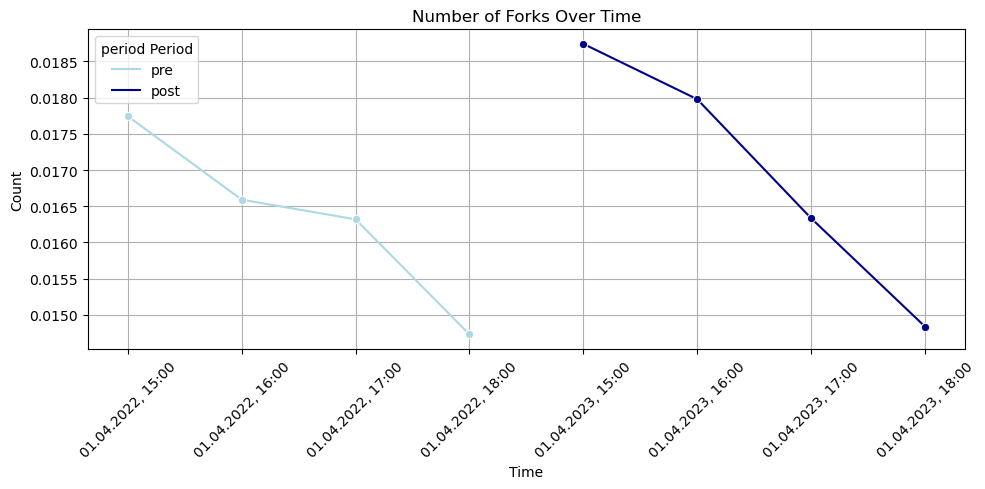

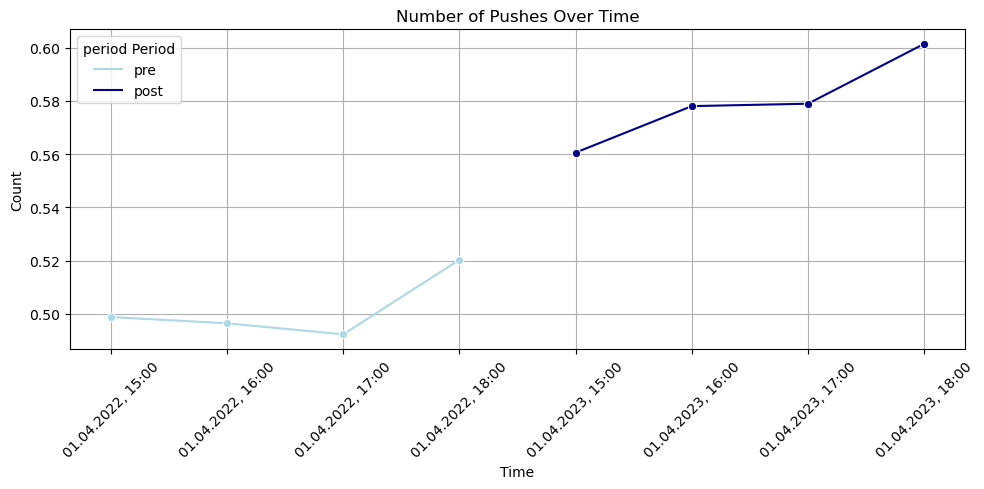

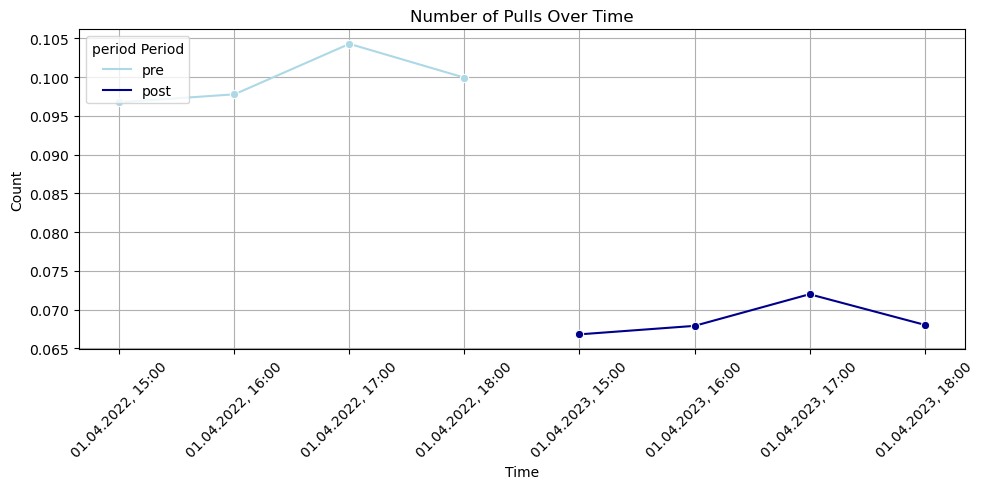

In [10]:
# Check if 'time_id' is not of datetime dtype and convert if necessary
if not pd.api.types.is_datetime64_any_dtype(panel_data['time_id']):
    panel_data['time_id'] = pd.to_datetime(panel_data['time_id'], format='%d.%m.%Y, %H:%M')
panel_data['time_id'] = panel_data['time_id'].dt.strftime('%d.%m.%Y, %H:%M')

# Creating a copy might be necessary to avoid warnings, but if it's not needed, you can remove this line.
panel_data = panel_data.copy()

# Group the data by 'time_id' and 'period' and calculate the average of each event type
grouped = panel_data.groupby(['time_id', 'period']).agg({'is_fork': 'mean', 'is_push': 'mean', 'is_pull': 'mean'})
grouped.reset_index(inplace=True)

metrics = ['is_fork', 'is_push', 'is_pull']
titles = ['Number of Forks Over Time', 'Number of Pushes Over Time', 'Number of Pulls Over Time']

for metric, title in zip(metrics, titles):
    plt.figure(figsize=(10, 5))

    # Plotting lines for 'pre' and 'post' separately
    sns.lineplot(
        x='time_id', y=metric, hue='period', 
        palette={'pre': 'lightblue', 'post': 'darkblue'},  # Assigning colors
        marker='o', 
        data=grouped, 
        sort=False
    )
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='period Period', loc='upper left')  # Adding a legend to differentiate 'pre' and 'post'
    plt.show()

# Setting up the DiD Framework

### Creating Interaction Term (between 'period' and 'Treatment' variables) catching the treatment effect

In [11]:
# Create a copy of the dataframe to avoid SettingWithCopyWarning
panel = panel.copy()

# Convert 'time_id' to datetime, 'period' to numerical, ensure 'Treatment' is of type int
panel['time_id'] = pd.to_datetime(panel['time_id'], format='%d.%m.%Y, %H:%M')
panel['period'] = panel['period'].replace({'pre': 0, 'post': 1}).astype(int)
panel['Treatment'] = panel['Treatment'].replace({0: 0, 1: 1}).astype(int)
print(panel[['Treatment', 'period']].dtypes)

# Create the interaction term
panel['treat_period'] = panel['Treatment'] * panel['period']

# For the regression, it's better to have numerical variables, so converting the booleans to int (False:0, True:1)
panel[['is_fork', 'is_push', 'is_pull']] = panel[['is_fork', 'is_push', 'is_pull']].astype(int)

Treatment    int32
period       int32
dtype: object


In [38]:
panel.head()

,Treatment,period,is_fork,is_push,is_pull,treat_post
0,1,0,0,1,0,0
1,1,0,0,1,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,1,0,0


# 3. Checking if Parallel Trends Assumption is met

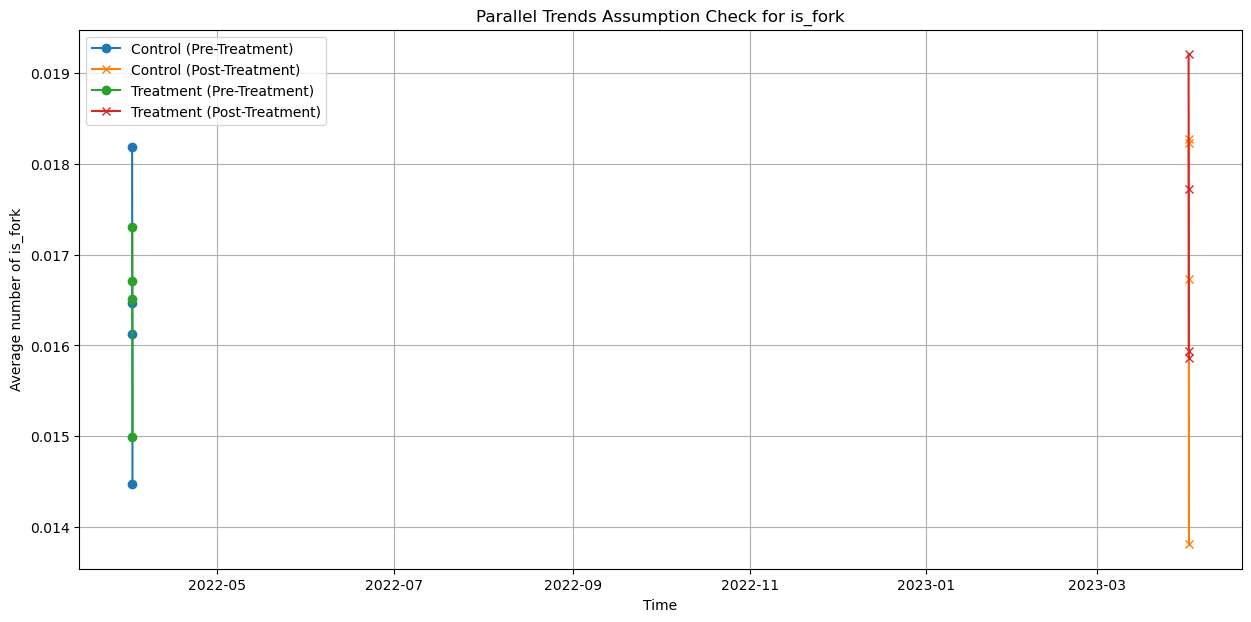

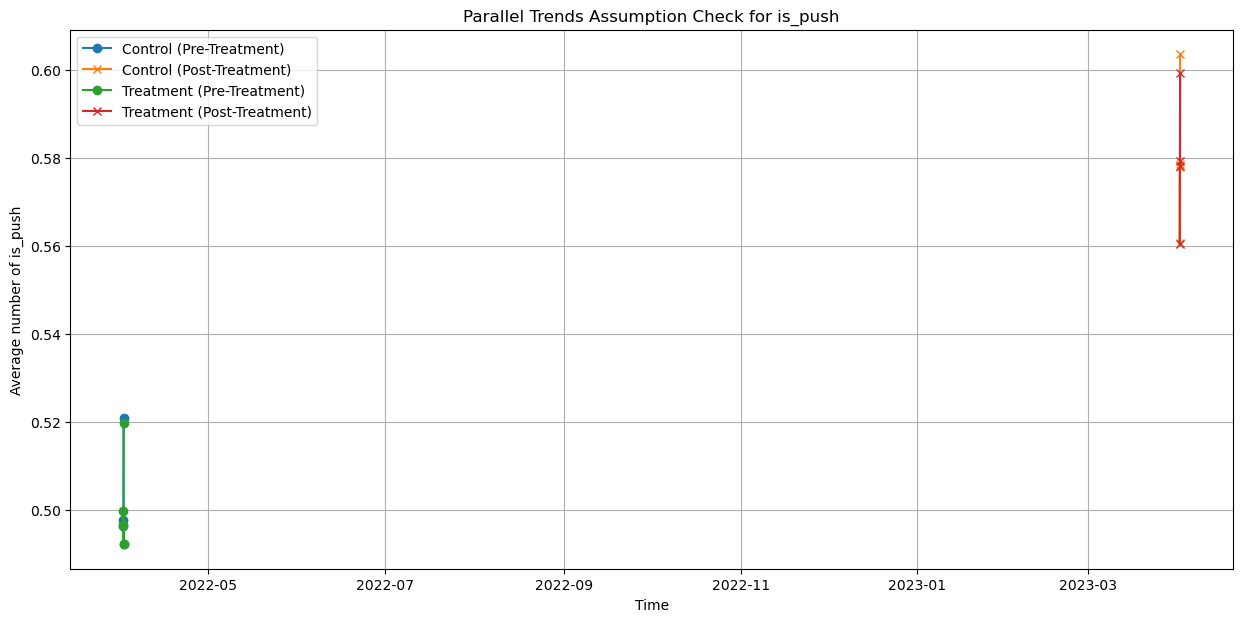

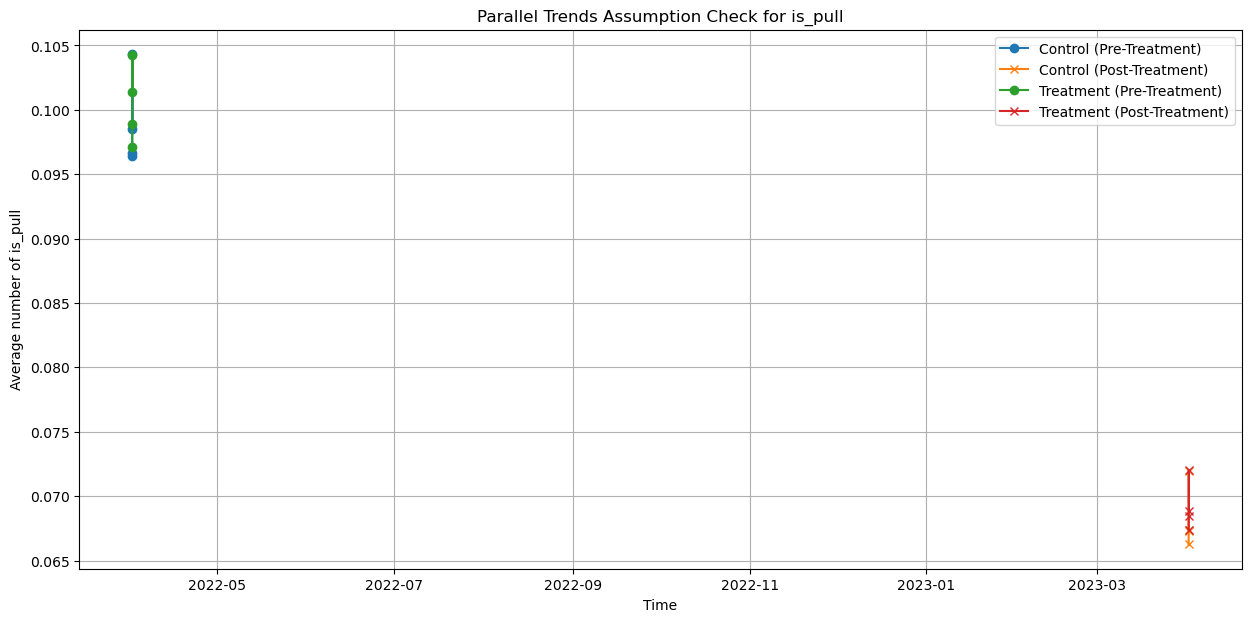

In [13]:
# Aggregate data at the 'time_id' level for each action. We calculate the mean because these are binary flags (0/1).
agg_data = panel.groupby(['time_id', 'Treatment', 'period'], as_index=False).agg({'is_fork': 'mean', 'is_push': 'mean', 'is_pull': 'mean'})

# Now, we'll plot the trends for each action. We do this for 'is_fork', 'is_push', and 'is_pull' to check if any of these metrics show parallel trends.
for action in ['is_fork', 'is_push', 'is_pull']:
    plt.figure(figsize=(15, 7))

    # Plot for control group (where Treatment == 0)
    control_group = agg_data[agg_data['Treatment'] == 0]
    trends_control = control_group.pivot(index='time_id', columns='period', values=action)
    plt.plot(trends_control.index, trends_control[0], label='Control (Pre-Treatment)', marker='o')  # period '0' is pre-treatment
    plt.plot(trends_control.index, trends_control[1], label='Control (Post-Treatment)', marker='x')  # period '1' is post-treatment

    # Plot for treatment group (where Treatment == 1)
    treatment_group = agg_data[agg_data['Treatment'] == 1]
    trends_treatment = treatment_group.pivot(index='time_id', columns='period', values=action)
    plt.plot(trends_treatment.index, trends_treatment[0], label='Treatment (Pre-Treatment)', marker='o')
    plt.plot(trends_treatment.index, trends_treatment[1], label='Treatment (Post-Treatment)', marker='x')

    plt.title(f'Parallel Trends Assumption Check for {action}')
    plt.ylabel(f'Average number of {action}')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.show()

### Interpretation - what to look out for when looking at the graphs (once we use the full dataset)
- Pre-Treatment Trends: The lines for Italy and Germany should move in parallel, showing a similar trajectory
- Divergence Post-Treatment: If the treatment had an effect, the two lines might diverge post GPT
- Consistency Across Metrics: If the same trend is consistent across all metrics, there is stronger validation for the assumption

# 4.Calculate DiD Estimates

In [17]:
from dask.distributed import Client
import dask.dataframe as dd
# Start a local Dask client
client = Client()

C:\Users\Kim\AppData\Local\anaconda3\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53380 instead
  warnings.warn(


In [21]:
# Set up the mean calculations without actually computing them
necessary_columns = ['Treatment', 'period', 'is_fork', 'is_push', 'is_pull']
panel = panel[necessary_columns]

control_pre_mean = panel[(panel['Treatment'] == 0) & (panel['period'] == 0)].mean()
control_post_mean = panel[(panel['Treatment'] == 0) & (panel['period'] == 1)].mean()
treatment_pre_mean = panel[(panel['Treatment'] == 1) & (panel['period'] == 0)].mean()
treatment_post_mean = panel[(panel['Treatment'] == 1) & (panel['period'] == 1)].mean()

In [22]:
# Compute the means and unpack the results
control_pre, control_post, treatment_pre, treatment_post = dd.compute(
    control_pre_mean, control_post_mean, treatment_pre_mean, treatment_post_mean
)

print("Step 1 Completed: Calculated means for pre-treatment and post-treatment periods.")

Step 1 Completed: Calculated means for pre-treatment and post-treatment periods.


In [23]:
# Calculate the first differences
diff_control = control_post - control_pre
diff_treatment = treatment_post - treatment_pre

print("Step 2 Completed: Calculated the first differences.")

Step 2 Completed: Calculated the first differences.


In [24]:
# Calculate the DiD estimator
did_estimator = diff_treatment - diff_control

print("Step 3 Completed: Calculated the Difference in Differences Estimator.")

Step 3 Completed: Calculated the Difference in Differences Estimator.


In [30]:
# Check and print specific columns, if they exist
try:
    print(did_estimator[['is_fork', 'is_push', 'is_pull']])
except KeyError:
    print("Some of the specified columns are not present in the 'did_estimator' DataFrame.")

is_fork    0.000373
is_push   -0.001077
is_pull   -0.000483
dtype: float64


# 5. Fit one Regression per analysed metric

In [33]:
# Create the interaction term between the treatment and the post-treatment period indicator.
panel['treat_post'] = panel['Treatment'] * panel['period']

# Now, set up your regression model. You're interested in the 'treat_post' coefficient,
# as it represents the treatment effect from the DiD setup.

# We will run separate regressions for each outcome ('is_fork', 'is_push', 'is_pull') as dependent variables.
outcomes = ['is_fork', 'is_push', 'is_pull']
for outcome in outcomes:
    formula = f'{outcome} ~ Treatment + period + treat_post'
    
    # Fit the regression model using ordinary least squares (OLS)
    model = smf.ols(formula=formula, data=panel).fit()
    print(f"Results for {outcome}:")
    print(model.summary())
    print("\n---\n")

# The summary output for each model inlcudesthe p-values and the DiD estimator ('treat_post')

Results for is_fork:
                            OLS Regression Results                            
Dep. Variable:                is_fork   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.130
Date:                Tue, 17 Oct 2023   Prob (F-statistic):             0.0245
Time:                        17:30:46   Log-Likelihood:             8.1795e+05
No. Observations:             1285782   AIC:                        -1.636e+06
Df Residuals:                 1285778   BIC:                        -1.636e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0164      0.00

## Interpretation of DiD Estimates and significance levels
The DiD analysis indicates that the treatment had no statistically significant impact on the 'is_fork', 'is_push', and 'is_pull' metrics, suggesting that the observed changes in these behaviors cannot be attributed to the intervention under study (for this preliminary sample)

# (Outdated EDA)

## Calculate different metrics to measure collaboration on repository-level and store in new df 'repos'

In [34]:
# Extracting repository name and id for easy grouping
commits['repo_name'] = commits['repo'].apply(lambda x: x['name'])
commits['repo_id'] = commits['repo'].apply(lambda x: x['id'])
commits['actor_login'] = commits['actor'].apply(lambda x: x['login'])

# Calculating metrics
grouped = commits.groupby(['repo_name', 'repo_id'])

forks_per_repo = grouped.apply(lambda x: (x['type'] == 'ForkEvent').sum())
push_per_repo = grouped.apply(lambda x: (x['type'] == 'PushEvent').sum())
pull_per_repo = grouped.apply(lambda x: (x['type'] == 'PullRequestEvent').sum())
unique_contributors_per_repo = grouped['actor_login'].nunique()
total_contributors_per_repo = grouped['actor_login'].size()

# Combining metrics into a new dataframe
repos = pd.DataFrame({
    'Forks': forks_per_repo,
    'Pushes': push_per_repo,
    'Pulls': pull_per_repo,
    'UniqueContributors': unique_contributors_per_repo,
    'TotalContributions': total_contributors_per_repo,
}).reset_index()
repos.head()

,repo_name,repo_id,Forks,Pushes,Pulls,UniqueContributors,TotalContributions
0,0-ALIK/BlocNotas,476834303,0,1,0,1,3
1,0-ALIK/GameTresEnRaya,476819751,0,2,0,1,3
2,0-AutomationCode/tab-icons,597952501,0,1,0,1,1
3,0-BSCode/0-BSCode,532507797,0,1,0,1,1
4,0-haha/earthquake_notification,622288089,0,3,0,1,5


In [35]:
repos.describe()

,repo_id,Forks,Pushes,Pulls,UniqueContributors,TotalContributions
count,3.528330e+05,352833.000000,352833.000000,352833.000000,352833.000000,352833.000000
mean,4.422289e+08,0.060796,1.965689,0.308330,1.245618,3.644166
std,1.680099e+08,0.950295,24.312085,2.138107,5.186214,26.568307
min,1.300000e+02,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.678102e+08,0.000000,0.000000,0.000000,1.000000,1.000000
50%,4.758566e+08,0.000000,1.000000,0.000000,1.000000,2.000000
75%,6.027183e+08,0.000000,2.000000,0.000000,1.000000,3.000000
max,6.223206e+08,474.000000,9721.000000,802.000000,2844.000000,9721.000000


### Visualisations

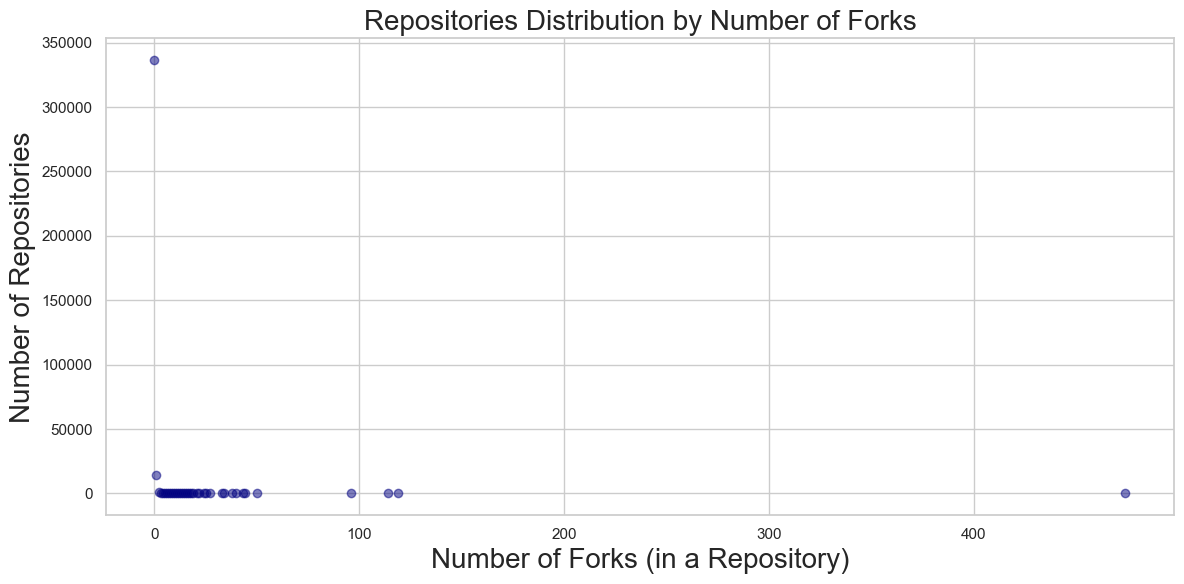

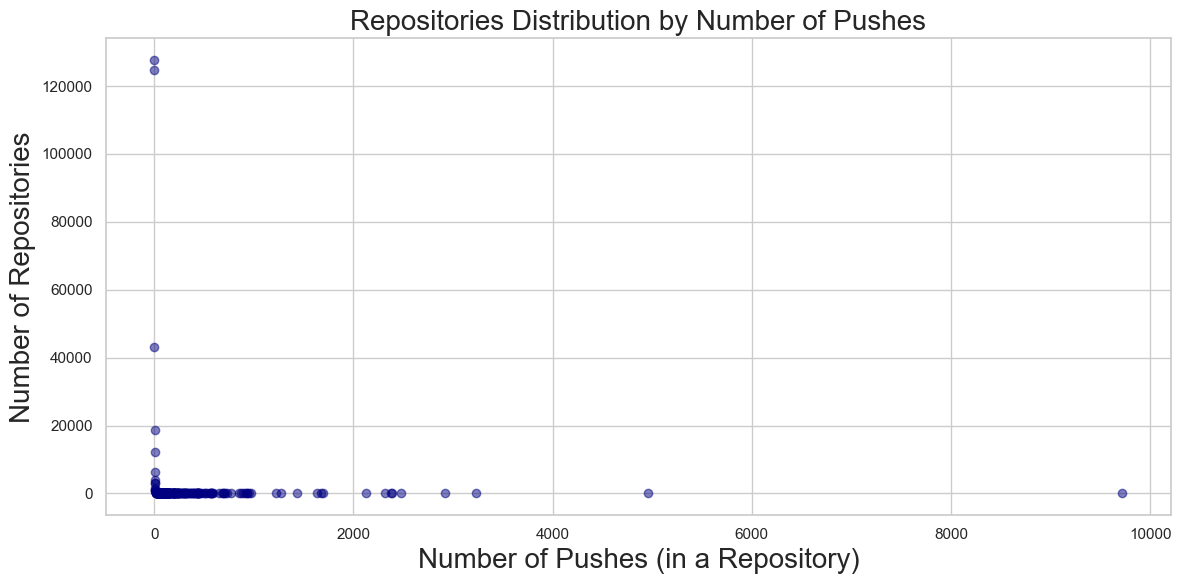

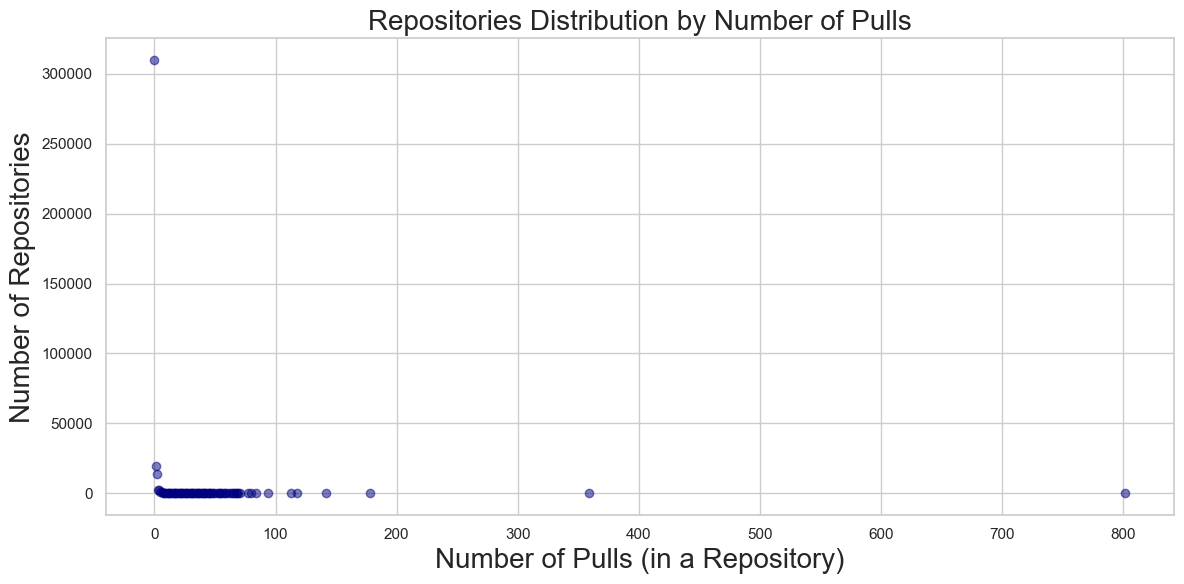

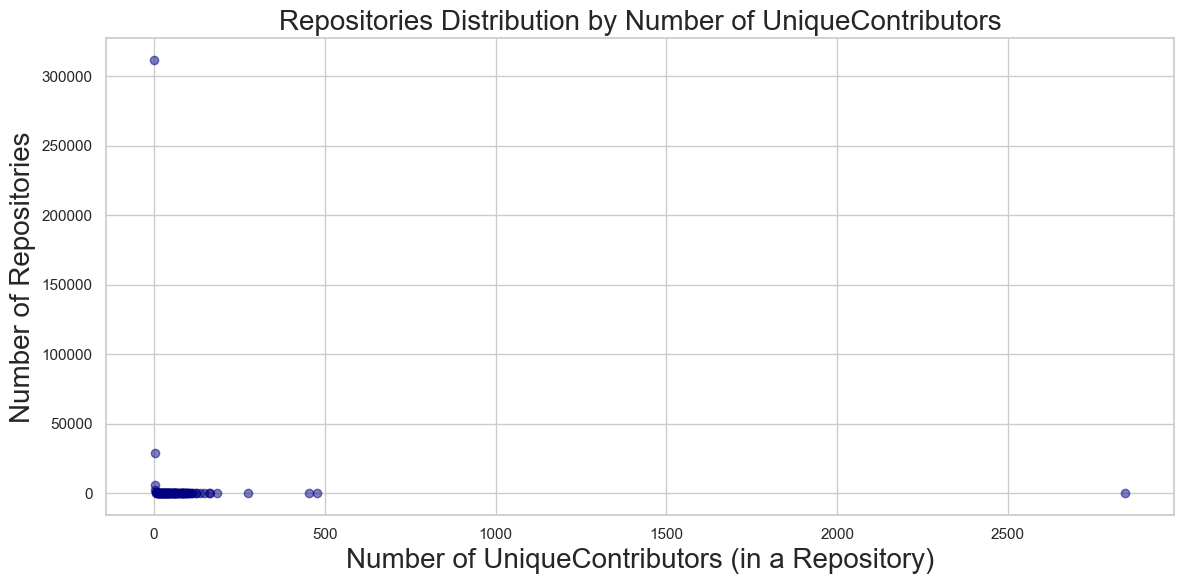

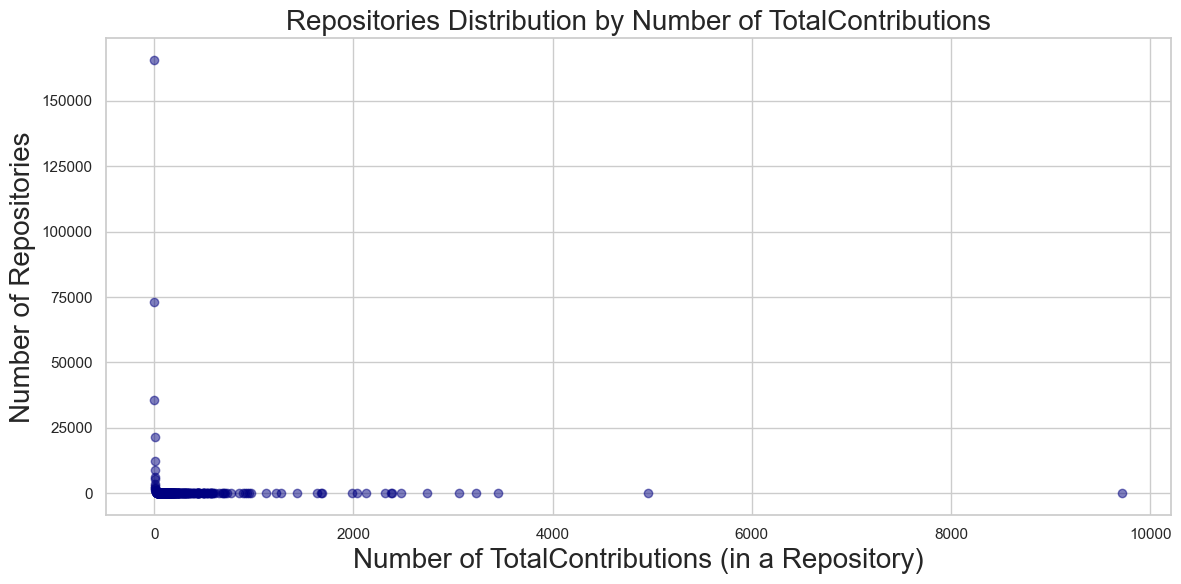

In [36]:
sns.set_theme(style="whitegrid")
metrics = ['Forks', 'Pushes', 'Pulls', 'UniqueContributors', 'TotalContributions']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    value_counts = repos[metric].value_counts().sort_index()
    plt.scatter(value_counts.index, value_counts.values, alpha=0.5, color='navy')
    plt.title(f'Repositories Distribution by Number of {metric}', fontsize=20)
    plt.xlabel(f'Number of {metric} (in a Repository)', fontsize=20)
    plt.ylabel(f'Number of Repositories', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()